## Evaluation of Calibration Methods

The human bias is in some ways encoded in the dataset, and models built using these datasets might amplify the bias and this could lead to a potential harm agaist unprivileged groups. The aim of this work is to prevent or mitigate the bias, and for that we evaluate the performance of several calibration methods independently of each other and see if the bias is reduced or not. Additionally we explore fairness combining several calibrarion methods in the same pipeline. For this purposes we are going to use aif360 package.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from utils import *

### 1. Load data

For the analysis we are going to use the Homicide  Reports,  1980-2014 dataset (https://www.kaggle.com/murderaccountability/homicide-reports).   The  data  was  compiled and made available by the Murder Accountability Project, founded by ThomasHargrove. 

In [2]:
data = pd.read_csv('../data/database.csv', na_values=['Unknown', ' '])

Before computing the metrics for fairness measurement, we first preprocess the data.

### 2. Preprocessing

In [3]:
print('Data dimensions are:', data.shape)

Data dimensions are: (638454, 24)


In [4]:
data.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,NaN,Male,15.0,Native American/Alaska Native,NaN,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,1,FBI


In [5]:
# Removing non useful columns
data.drop(columns=['Record ID', 'Agency Code', 'Perpetrator Ethnicity'], inplace=True)

In [6]:
# Getting rid off non solved cases, since we are interested on the impact of solved incidents.
print(data['Crime Solved'].value_counts())
data = data[data['Crime Solved'] == 'Yes']

Yes    448172
No     190282
Name: Crime Solved, dtype: int64


In [7]:
data.shape

(448172, 21)

In [8]:
# To get more insights we build Perpetrator Age Category
# We'll consider the following
# > 65 'Elder', < 25 'Young' and 'Adult' if >= 25 and <= 65
data['Perpetrator Age category'] = 'Missing'
data['Perpetrator Age category'] = np.where(data['Perpetrator Age'] > 64, 'Elder', np.where(data['Perpetrator Age'] < 25, 'Young', 'Adult'))

In [9]:
data['Perpetrator Age category'].unique()

array(['Young', 'Adult', 'Elder'], dtype=object)

In [10]:
# Lets create catergorical and numerical variable
skip = ['Crime Solved', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']

num_columns, cat_columns = get_columns(data, skip)

#### Handling missing values

In [11]:
# Number of missing values
data.isna().sum()

Agency Name                     33
Agency Type                      0
City                             0
State                            0
Year                             0
Month                            0
Incident                         0
Crime Type                       0
Crime Solved                     0
Victim Sex                     331
Victim Age                       0
Victim Race                   3592
Victim Ethnicity            255032
Perpetrator Sex                147
Perpetrator Age                  0
Perpetrator Race              6049
Relationship                 94892
Weapon                       18409
Victim Count                     0
Perpetrator Count                0
Record Source                    0
Perpetrator Age category         0
dtype: int64

In [12]:
# We are going to fill with median values 
median_val = pd.Series()
for col in num_columns:
    if col not in ['Crime Solved']:
        median_val[col] = data[col].median()

In [13]:
data = handle_missing_values(data, median_val)

#### Visualization

We will choose **Perpetrator Sex** and **Perpetrator Race** as our target variables, so let's see the distributions of this variables

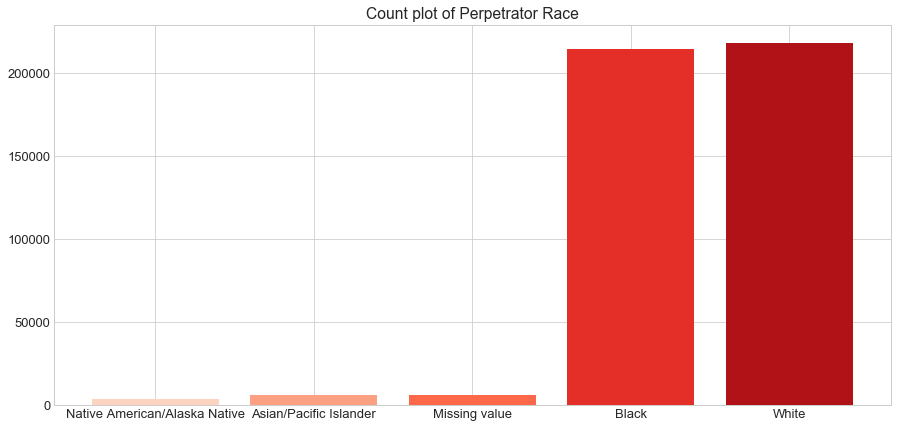

In [14]:
target_distribution(y_var='Perpetrator Race', data=data)

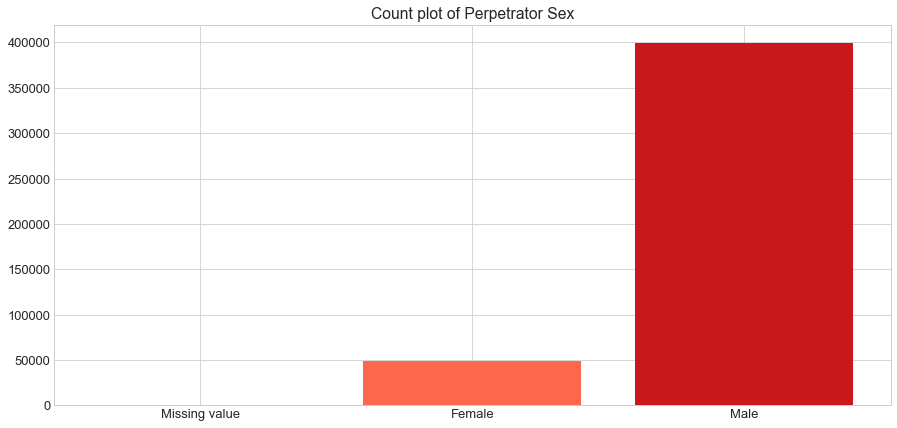

In [15]:
target_distribution(y_var='Perpetrator Sex', data=data)

Additionally we will see for the **Perpetrator Age Category**

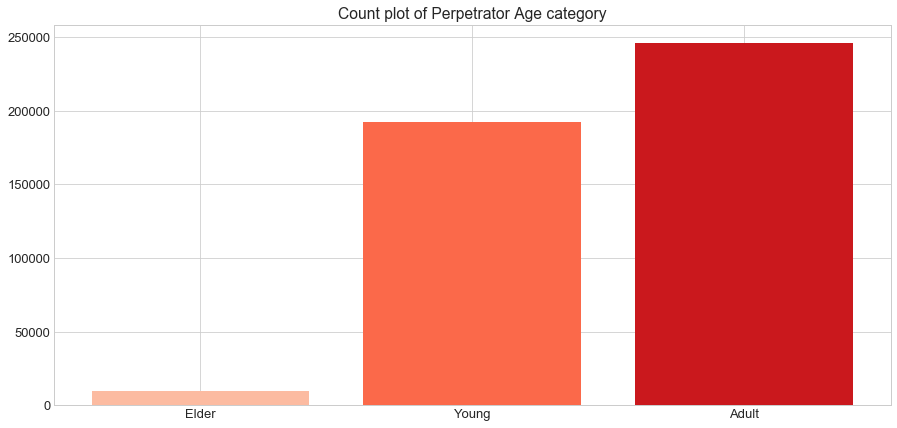

In [16]:
target_distribution(y_var='Perpetrator Age category', data=data)

In [17]:
# Let's see the frecuency of crimes for the target variables
data['Frequency'] = 1
freq_target = data[['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category', 'Frequency']]
del data['Frequency']
freq_target = freq_target.groupby(by=['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']).count() / len(data)
print(freq_target.sort_values(by='Frequency', ascending=False))

                                                                        Frequency
Perpetrator Sex Perpetrator Race              Perpetrator Age category           
Male            White                         Adult                      0.264265
                Black                         Young                      0.220366
                                              Adult                      0.197418
                White                         Young                      0.159222
Female          Black                         Adult                      0.035841
                White                         Adult                      0.034741
                Black                         Young                      0.018415
                White                         Young                      0.013767
Male            White                         Elder                      0.013439
                Missing value                 Young                      0.008546
                

#### Handling outliers

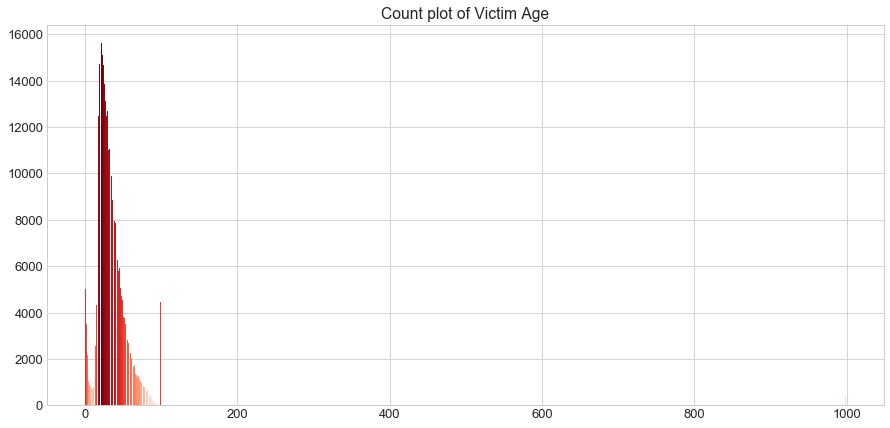

In [18]:
# Let's check on ages
target_distribution(y_var='Victim Age', data=data)

In [19]:
data['Victim Age'].describe()

count    448172.000000
mean         34.008200
std          32.806341
min           0.000000
25%          22.000000
50%          30.000000
75%          42.000000
max         998.000000
Name: Victim Age, dtype: float64

From the plot and the summary of **Victim Age** shown above, we can see that we have outliers

In [20]:
data['Victim Age'] = np.where(data['Victim Age'] == 998, np.median(data[data['Victim Age'] <= 100]['Victim Age']), data['Victim Age'])

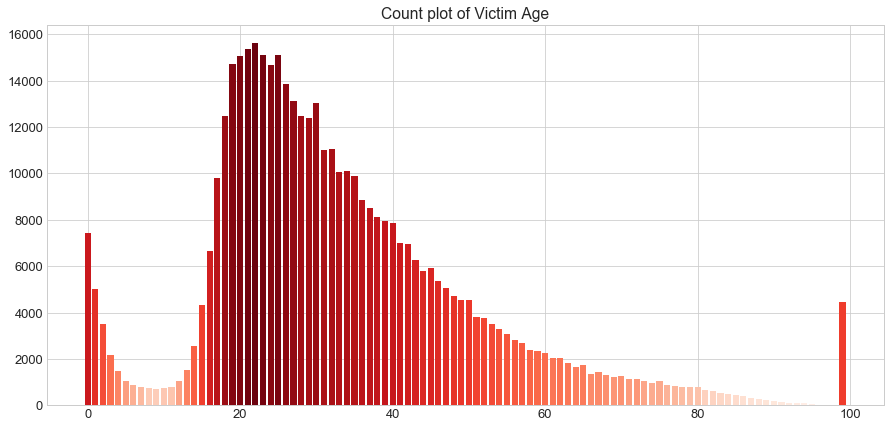

In [21]:
target_distribution(y_var='Victim Age', data=data)

Now is much better

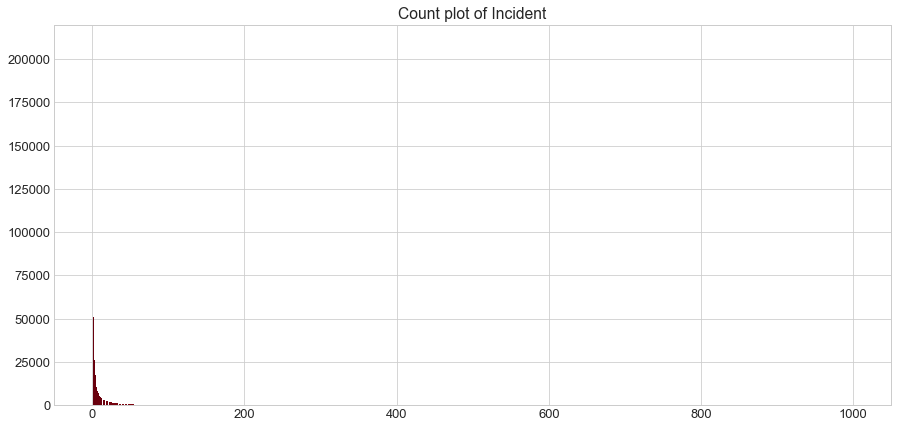

In [24]:
# Let's see the distribution of 'Incident'
target_distribution(y_var='Incident', data=data)

We can see that this variable is useless, so let's drop it

In [25]:
# Variables to drop
data.drop(['Incident'], axis=1, inplace=True)

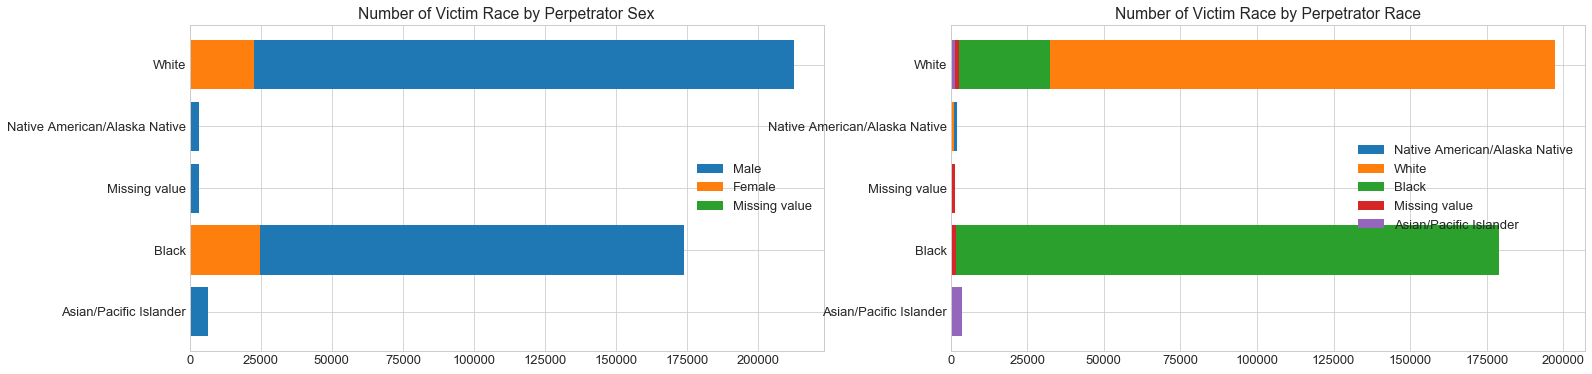

In [23]:
# Vis of Target variable against 'protected features'
Y_columns = ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
plot_bar(data, col='Victim Race',Y_columns=Y_columns)

#### Encoding Categorical Features

To work with the different metrics or any other algorithms, we need to encode our categorical variables to numerical values

In [27]:
categorical_features = cat_columns + ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
# categorical_features = categorical_features 
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]


In [28]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le